In [1]:
%matplotlib notebook
%pylab
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pyradise as prs

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
#
# Definining reader, tag and wireless transmission, or environment, parameters.
#

# environment parameters
speed_of_light = 2.99792458 * 10e8
frequency = 860*10e6
wave_length = speed_of_light / frequency
thermal_noise = -116 #dBm
permittivity = 15
conductivity = 0.03

# reader paramters
reader_height = 5.0 #m
reader_angle  = pi/4
reader_tx_power = 31.5 #dBm
reader_antenna_gain = 6 #dBi
reader_noise  = -80 #dBm
reader_cabel_loss = -2 

# tag parameters 
tag_speed = 20 #mps
tag_height = 0.5 #m
tag_angle  = pi/2
tag_antenna_gain = 2 #dBi 
tag_modulation_loss = -12.0 #dB
tag_sensitivity=-17.5 #dBm

# mutual parameters
polarization_loss = -3.0 #dB
ceil_height = 6

In [3]:
def patch_rp_(theta, phi):
    return prs.patch_rp(azimuth=theta, tilt=phi, wavelen=wave_length, width=wave_length/2, length=wave_length/2)

def reflection_paral_(phi):
    return prs.reflection(grazing_angle=phi, polarization=1., permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)

def reflection_perp_(phi):
    return prs.reflection(grazing_angle=phi, polarization=0., permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)

def reflection_circ_(phi):
    return prs.reflection(grazing_angle=phi, polarization=.5, permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)


def fspl_(distance):
    return prs.free_space_path_loss_2d(distance=distance, 
            tx_rp=prs.patch_rp, rx_rp=prs.dipole_rp, tx_angle=reader_angle, rx_angle=tag_angle, tx_height=reader_height, 
            rx_height=tag_height, wavelen=wave_length, width=wave_length/2, length=wave_length/2)

def two_ray_(distance, time, speed, polarization):
    return prs.two_ray_path_loss(distance=distance, time=time, speed=speed, ground_reflection=prs.reflection,
            polarization=polarization, permittivity=permittivity, conductivity=conductivity,
            tx_rp=prs.dipole_rp, rx_rp=prs.dipole_rp, tx_angle=reader_angle, rx_angle=tag_angle, tx_height=reader_height, 
            rx_height=tag_height, wavelen=wave_length, width=wave_length/2, length=wave_length/2)


def make_space_time_greed_(distance, time, function, **kwargs):
    return np.array([[function(distance=d, time=t, **kwargs) for d in distance] for t in time])


In [4]:
#
# Link budget computation
#
def rx_power_tag_(pathloss):
    return (reader_tx_power + reader_antenna_gain + reader_cabel_loss + 
            pathloss + tag_antenna_gain + polarization_loss)

def tx_power_tag_(rx_power_tag):
    return rx_power_tag + tag_modulation_loss if rx_power_tag >= tag_sensitivity else thermal_noise

def rx_power_reader_(pathloss, tx_power_tag):    
    return (tx_power_tag + tag_antenna_gain + pathloss + polarization_loss +
                reader_cabel_loss + reader_antenna_gain) if tx_power_tag >= reader_noise else thermal_noise


def rx_power_tag_complete_(distance, time, speed):
    pathloss_fwd = prs.lin2db(two_ray_(distance, time, speed, .5))  # computing path loss from reader to tag 
    return rx_power_tag_(pathloss_fwd)

def rx_power_reader_complete_(distance, time, speed):
    pathloss_fwd = prs.lin2db(two_ray_(distance, time, speed, .5))  # computing path loss from reader to tag 
    rx_power_tag = rx_power_tag_(pathloss_fwd)                      # computing RX power at tag
    tx_power_tag = tx_power_tag_(rx_power_tag)                      # computing TX power of tag
    pathloss_bwd = prs.lin2db(two_ray_(distance, time, speed, 1.))  # computing path loss from tag to reader
    return rx_power_reader_(pathloss_bwd, tx_power_tag)

#
# SNR and BER computation
#
def snr_(distance, time, speed):
    rx_power = rx_power_reader_complete_(distance, time, speed)
    return prs.signal2noise(rx_power=rx_power, noise_power=reader_noise)

def ber_over_awgn_(distance, time, speed):
    snr = snr_(distance, time, speed)
    sync_angle = prs.sync_angle(snr=snr)
    snr_extended = prs.snr_extended(snr=snr, sync_phi=sync_angle)
    return prs.ber_over_awgn(snr=snr_extended)

def ber_over_rayleigh_(distance, time, speed):
    snr = snr_(distance, time, speed)
    sync_angle = prs.sync_angle(snr=snr)
    snr_extended = prs.snr_extended(snr=snr, sync_phi=sync_angle)
    return prs.ber_over_rayleigh(snr=snr_extended)


In [5]:
tx_position_3d        = np.array([0,0,reader_height])
tx_direction_theta_3d = np.array([np.sin(reader_angle), 0, -np.cos(reader_angle)])
tx_direction_phi_3d   = np.array([0,1,0])
tx_velocity_3d        = np.array([0,0,0])

rx_direction_theta_3d = np.array([-1,0,0])
rx_direction_phi_3d   = np.array([0,-1,0])

def two_ray_3d_(distance, time, speed, polarization):
    return prs.two_ray_path_loss_3d(time=time, ground_reflection=prs.reflection, 
            polarization=polarization, permittivity=permittivity, conductivity=conductivity,
            tx_pos=tx_position_3d, tx_dir_theta=tx_direction_theta_3d, tx_dir_phi=tx_direction_phi_3d, 
                                    tx_velocity=tx_velocity_3d, tx_rp=prs.patch_rp,
#                                     tx_velocity=tx_velocity_3d, tx_rp=prs.dipole_rp,
            rx_pos=np.array([distance,0,tag_height]), rx_dir_theta=rx_direction_theta_3d, rx_dir_phi=rx_direction_phi_3d, 
                                    rx_velocity=np.array([-speed,0,0]), rx_rp=prs.dipole_rp, 
            wavelen=wave_length, width=wave_length/2, length=wave_length/2)

def two_ray_3d_inverse_(distance, time, speed, polarization):
    return prs.two_ray_path_loss_3d(time=time, ground_reflection=prs.reflection, 
            polarization=polarization, permittivity=permittivity, conductivity=conductivity,
            tx_pos=np.array([distance,0,tag_height]), tx_dir_theta=rx_direction_theta_3d, tx_dir_phi=rx_direction_phi_3d, 
#             tx_velocity=tx_velocity_3d, tx_rp=prs.patch_rp,
                                    tx_velocity=np.array([speed,0,0]), tx_rp=prs.dipole_rp,
            rx_pos=tx_position_3d, rx_dir_theta=tx_direction_theta_3d, rx_dir_phi=tx_direction_phi_3d, 
                                    rx_velocity=tx_velocity_3d, rx_rp=prs.dipole_rp, 
            wavelen=wave_length, width=wave_length/2, length=wave_length/2)


def rx_power_tag_complete_3d_(distance, time, speed):
    pathloss_fwd = prs.lin2db(two_ray_3d_(distance, time, speed, 0.5))  # computing path loss from reader to tag 
    return rx_power_tag_(pathloss_fwd)


def tx_power_tag_complete_3d_(distance, time, speed):
    rx_power_tag = rx_power_tag_complete_3d_(distance, time, speed)
    return rx_power_tag + tag_modulation_loss if rx_power_tag >= tag_sensitivity else thermal_noise


def rx_power_reader_complete_3d_(distance, time, speed):
    pathloss_fwd = prs.lin2db(two_ray_3d_(distance, time, speed, .5))  # computing path loss from reader to tag 
    rx_power_tag = rx_power_tag_(pathloss_fwd)                      # computing RX power at tag
    tx_power_tag = tx_power_tag_(rx_power_tag)                      # computing TX power of tag
    pathloss_bwd = prs.lin2db(two_ray_3d_(distance, time, speed, 1.))  # computing path loss from tag to reader
    return rx_power_reader_(pathloss_bwd, tx_power_tag)


def snr_3d_(distance, time, speed):
    rx_power = rx_power_reader_complete_3d_(distance, time, speed)
    return prs.signal2noise(rx_power=rx_power, noise_power=reader_noise)


def ber_over_awgn_3d_(distance, time, speed):
    snr = snr_3d_(distance, time, speed)
    sync_angle = prs.sync_angle(snr=snr, preamble_duration=825e-6)
    snr_extended = prs.snr_extended(snr=snr, sync_phi=sync_angle, symbol_duration=9.375e-6, miller=4)
    return prs.ber_over_awgn(snr=snr_extended)


def ber_over_rayleigh_3d_(distance, time, speed):
    snr = snr_3d_(distance, time, speed)
    sync_angle = prs.sync_angle(snr=snr, preamble_duration=825e-6)
    snr_extended = prs.snr_extended(snr=snr, sync_phi=sync_angle, symbol_duration=4.6875e-6, miller=4)
    return prs.ber_over_rayleigh(snr=snr_extended)



prs.lin2db(two_ray_3d_(4.5, 0.0, 0, 0.5))

array(-51.914586741379864)

In [6]:
#
# Antenna gain computation
#
def antenna_gain_(radiation_pattern, theta, **kwargs):
    max_gain  = radiation_pattern(azimuth=0, **kwargs)
    mean_gain = np.sum([radiation_pattern(azimuth=t, **kwargs) for t in theta]) / theta.size
    return prs.lin2db(max_gain / mean_gain)

def antenna_gain_2d_(radiation_pattern, theta, tilt, **kwargs):
    max_gain  = radiation_pattern(0, tilt, **kwargs)
    mean_gain = np.sum([radiation_pattern(t, tilt, **kwargs) for t in theta]) / theta.size
    return prs.lin2db(max_gain / mean_gain)

theta = np.linspace(-pi, pi, num=100)

gain_iso = antenna_gain_(prs.isotropic_rp, theta)
gain_dip = antenna_gain_(prs.dipole_rp, theta)
gain_arr = antenna_gain_(prs.array_dipole_rp, theta, n=2)
gain_hel = antenna_gain_(prs.helix_rp, theta, n=3)

print(gain_iso, gain_dip, gain_arr, gain_hel)

gain_patch_0 = antenna_gain_2d_(patch_rp_, theta, 0.0)
gain_patch_1 = antenna_gain_2d_(patch_rp_, theta, pi/6)
gain_patch_2 = antenna_gain_2d_(patch_rp_, theta, pi/4)
gain_patch_3 = antenna_gain_2d_(patch_rp_, theta, pi/3)
gain_patch_4 = antenna_gain_2d_(patch_rp_, theta, pi/12*5)

print(gain_patch_0, gain_patch_1, gain_patch_2, gain_patch_3, gain_patch_4)

0.0 5.349029975306875 6.314535216429676 5.392705253793354
6.314535216429675 5.67962938579154 5.334393666807177 5.252871482124313 5.417786106090564


<IPython.core.display.Javascript object>


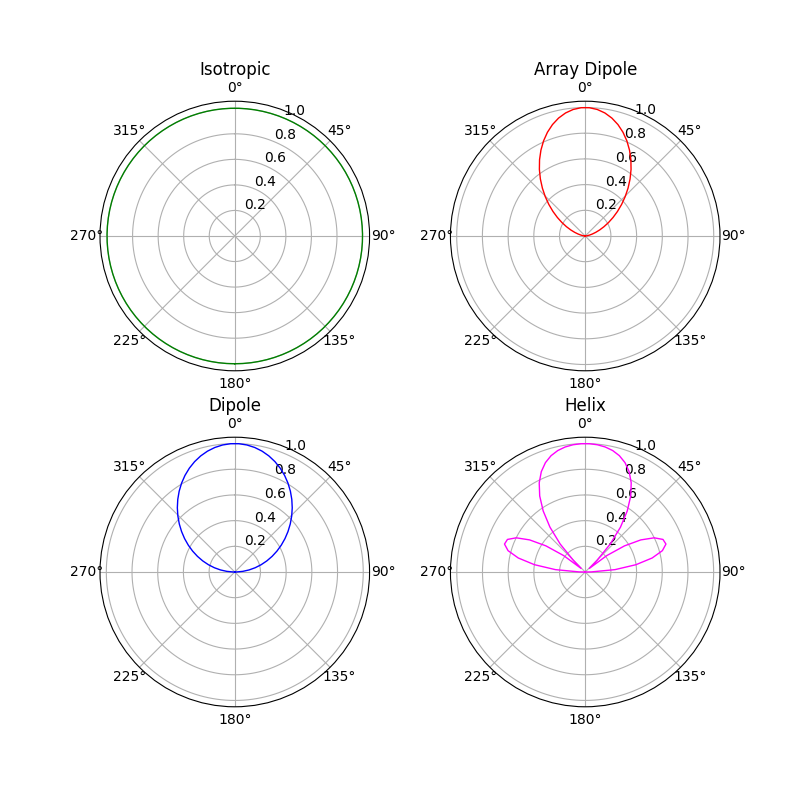

In [7]:
#
# Plotting radiation pattern of different antennas
#
theta = np.linspace(-pi, pi, num=100)
r1 = [prs.isotropic_rp(azimuth=t) for t in theta]
r2 = [prs.dipole_rp(azimuth=t) for t in theta]
r3 = [prs.array_dipole_rp(azimuth=t, n=2) for t in theta]
r4 = [prs.helix_rp(azimuth=t, n=3) for t in theta]

figure(1, figsize=(8,8))
ax1 = subplot2grid((2,2), (0,0), projection='polar')
ax2 = subplot2grid((2,2), (1,0), projection='polar')
ax3 = subplot2grid((2,2), (0,1), projection='polar')
ax4 = subplot2grid((2,2), (1,1), projection='polar')

ax1.plot(theta, r1, color='green', linewidth=1)
ax2.plot(theta, r2, color='blue', linewidth=1)
ax3.plot(theta, r3, color='red', linewidth=1)
ax4.plot(theta, r4, color='magenta', linewidth=1)

ax1.set_theta_zero_location('N')
ax2.set_theta_zero_location('N')
ax3.set_theta_zero_location('N')
ax4.set_theta_zero_location('N')

ax1.set_title("Isotropic", va='bottom')
ax2.set_title("Dipole", va='bottom')
ax3.set_title("Array Dipole", va='bottom')
ax4.set_title("Helix", va='bottom')

ax1.set_theta_direction(-1)
ax2.set_theta_direction(-1)
ax3.set_theta_direction(-1)
ax4.set_theta_direction(-1)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

# ax.set_rscale('log')
# ax.set_rmax(0.008)
# ax.grid(True)

<IPython.core.display.Javascript object>


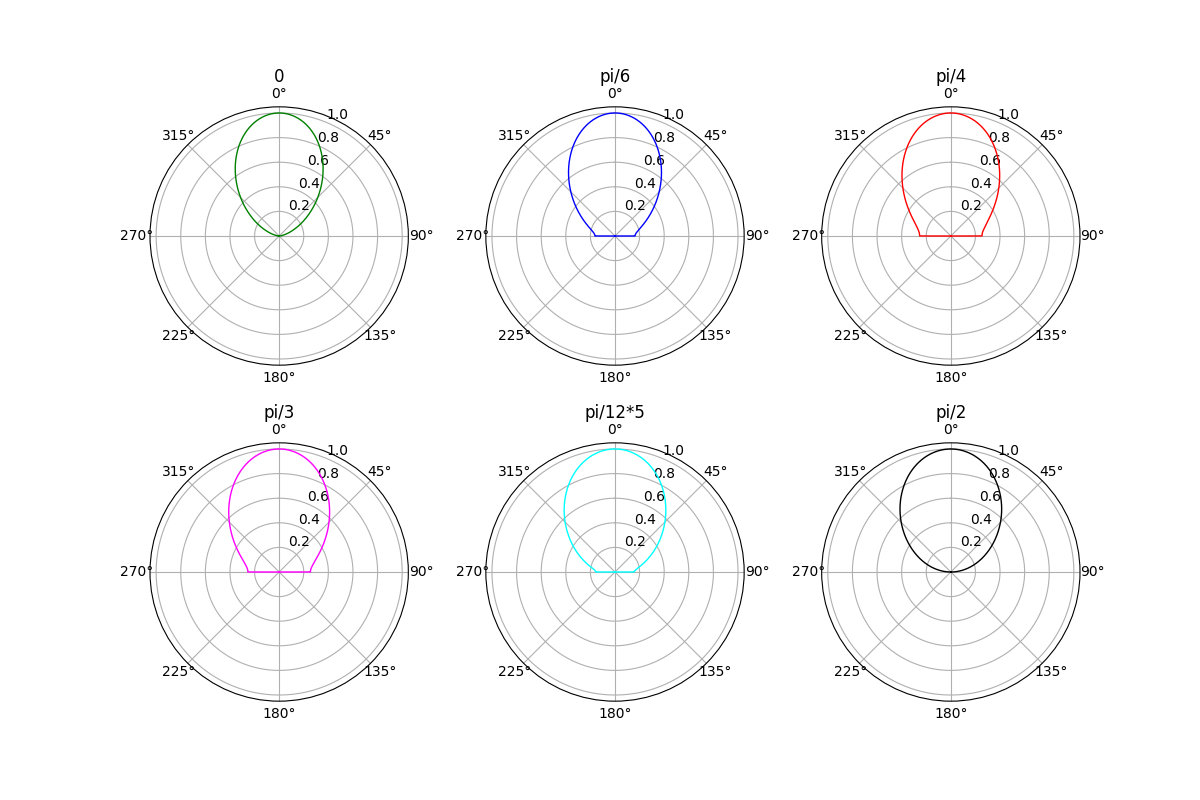

In [8]:
theta = np.linspace(-pi, pi, num=1000)

def log_rp(theta, phi, rp): 
    value = w2db(rp(theta, phi)) + 40
    if (value < 0):
        return 0
    else:
        return value


r1 = [patch_rp_(t, 0.0)  for t in theta]
r2 = [patch_rp_(t, pi/6) for t in theta]
r3 = [patch_rp_(t, pi/4) for t in theta]
r4 = [patch_rp_(t, pi/3) for t in theta]
r5 = [patch_rp_(t, pi/12*5) for t in theta]
r6 = [patch_rp_(t, pi/2) for t in theta]

# r1 = prs.patch_rp(azimuth=theta, tilt=0.001, wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r2 = prs.patch_rp(azimuth=theta, tilt=pi/12, wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r3 = prs.patch_rp(azimuth=theta, tilt=pi/6,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r4 = prs.patch_rp(azimuth=theta, tilt=pi/4,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r5 = prs.patch_rp(azimuth=theta, tilt=pi/3,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)
# r6 = prs.patch_rp(azimuth=theta, tilt=pi/2,  wavelen=wave_length, width=wave_length/2, length=wave_length/2)

figure(2, figsize=(12,8))
ax1 = subplot2grid((2,3), (0,0), projection='polar')
ax2 = subplot2grid((2,3), (0,1), projection='polar')
ax3 = subplot2grid((2,3), (0,2), projection='polar')
ax4 = subplot2grid((2,3), (1,0), projection='polar')
ax5 = subplot2grid((2,3), (1,1), projection='polar')
ax6 = subplot2grid((2,3), (1,2), projection='polar')

ax1.plot(theta, r1, color='green',   linewidth=1)
ax2.plot(theta, r2, color='blue',    linewidth=1)
ax3.plot(theta, r3, color='red',     linewidth=1)
ax4.plot(theta, r4, color='magenta', linewidth=1)
ax5.plot(theta, r5, color='cyan',    linewidth=1)
ax6.plot(theta, r6, color='black',   linewidth=1)

ax1.set_theta_zero_location('N')
ax2.set_theta_zero_location('N')
ax3.set_theta_zero_location('N')
ax4.set_theta_zero_location('N')
ax5.set_theta_zero_location('N')
ax6.set_theta_zero_location('N')

ax1.set_title("0", va='bottom')
ax2.set_title("pi/6", va='bottom')
ax3.set_title("pi/4", va='bottom')
ax4.set_title("pi/3", va='bottom')
ax5.set_title("pi/12*5", va='bottom')
ax6.set_title("pi/2", va='bottom')

ax1.set_theta_direction(-1)
ax2.set_theta_direction(-1)
ax3.set_theta_direction(-1)
ax4.set_theta_direction(-1)
ax5.set_theta_direction(-1)
ax6.set_theta_direction(-1)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

<IPython.core.display.Javascript object>


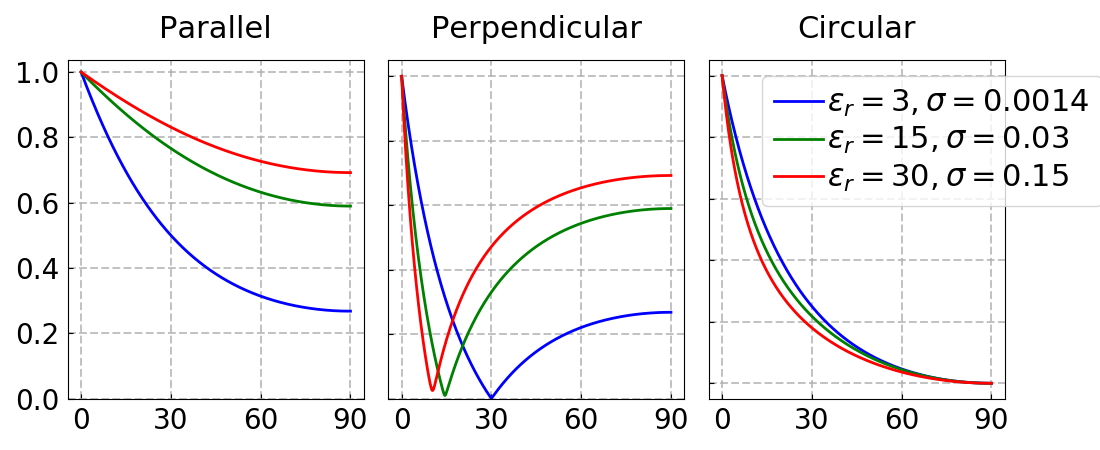

In [11]:
phi = np.linspace(0.0, pi/2, num=500)

r_pl_0 = [np.absolute(prs.reflection(grazing_angle=t, polarization=1., permittivity=3, conductivity=0.0014, 
                                   wavelen=wave_length))for t in phi]
r_pp_0 = [np.absolute(prs.reflection(grazing_angle=t, polarization=0., permittivity=3, conductivity=0.0014, 
                                   wavelen=wave_length))for t in phi]
r_c_0  = [np.absolute(prs.reflection(grazing_angle=t, polarization=.5, permittivity=3, conductivity=0.0014, 
                                   wavelen=wave_length))for t in phi]

r_pl_1 = [np.absolute(prs.reflection(grazing_angle=t, polarization=1., permittivity=15, conductivity=0.03, 
                                   wavelen=wave_length))for t in phi]
r_pp_1 = [np.absolute(prs.reflection(grazing_angle=t, polarization=0., permittivity=15, conductivity=0.03, 
                                   wavelen=wave_length))for t in phi]
r_c_1  = [np.absolute(prs.reflection(grazing_angle=t, polarization=.5, permittivity=15, conductivity=0.03, 
                                   wavelen=wave_length))for t in phi]

r_pl_2 = [np.absolute(prs.reflection(grazing_angle=t, polarization=1., permittivity=30, conductivity=0.15, 
                                   wavelen=wave_length))for t in phi]
r_pp_2 = [np.absolute(prs.reflection(grazing_angle=t, polarization=0., permittivity=30, conductivity=0.15, 
                                   wavelen=wave_length))for t in phi]
r_c_2  = [np.absolute(prs.reflection(grazing_angle=t, polarization=.5, permittivity=30, conductivity=0.15, 
                                   wavelen=wave_length))for t in phi]

fig = figure(30, figsize=(11,4.5))
plt.rc('font', family='sans-serif')

ax1 = subplot2grid((1,13), (0,0), colspan=4)
ax2 = subplot2grid((1,13), (0,4), colspan=4)
ax3 = subplot2grid((1,13), (0,8), colspan=4)
# ax4 = subplot2grid((1,4), (0,3))


label_str = "$\epsilon_{{r}}={0}, \sigma={1}$"

ax1.plot(phi*180/pi, r_pl_0, color='blue', linewidth=2)
ax2.plot(phi*180/pi, r_pp_0, color='blue', linewidth=2)
ax3.plot(phi*180/pi, r_c_0,  color='blue', linewidth=2, label=label_str.format(3, 0.0014))

ax1.plot(phi*180/pi, r_pl_1, color='green', linewidth=2)
ax2.plot(phi*180/pi, r_pp_1, color='green', linewidth=2)
ax3.plot(phi*180/pi, r_c_1,  color='green', linewidth=2, label=label_str.format(15, 0.03))

ax1.plot(phi*180/pi, r_pl_2, color='red', linewidth=2)
ax2.plot(phi*180/pi, r_pp_2, color='red', linewidth=2)
ax3.plot(phi*180/pi, r_c_2,  color='red', linewidth=2, label=label_str.format(30, 0.15))

ax1.set_xticks(arange(4)*30)
ax2.set_xticks(arange(4)*30)
ax3.set_xticks(arange(4)*30)
ax1.set_yticks(arange(6)/5.)
ax2.set_yticks(arange(6)/5.)
ax3.set_yticks(arange(6)/5.)
ax1.set_ybound(lower=0)
ax2.set_ybound(lower=0)
ax2.set_ybound(lower=0)
ax1.tick_params(labelsize=20, direction='in', pad=6)
ax2.tick_params(labelsize=20, direction='in', pad=6)
ax3.tick_params(labelsize=20, direction='in', pad=6)

ax2.set_yticklabels(['' for i in arange(6)])
ax3.set_yticklabels(['' for i in arange(6)])

ax1.set_title('Parallel', fontdict={'fontsize': 22}, y=1.04)
ax2.set_title('Perpendicular', fontdict={'fontsize': 22}, y=1.04)
ax3.set_title('Circular', fontdict={'fontsize': 22}, y=1.04)

ax1.grid(linestyle='--', linewidth=1.1)
ax2.grid(linestyle='--', linewidth=1.1)
ax3.grid(linestyle='--', linewidth=1.1)

plt.subplots_adjust(wspace=1.8, hspace=0.0)
plt.show()
fig.tight_layout()
legend(fontsize=22, handlelength=1.6, handletextpad=0.14, labelspacing=0.2, loc=(0.18, 0.57))
savefig('reflection.eps')

<IPython.core.display.Javascript object>


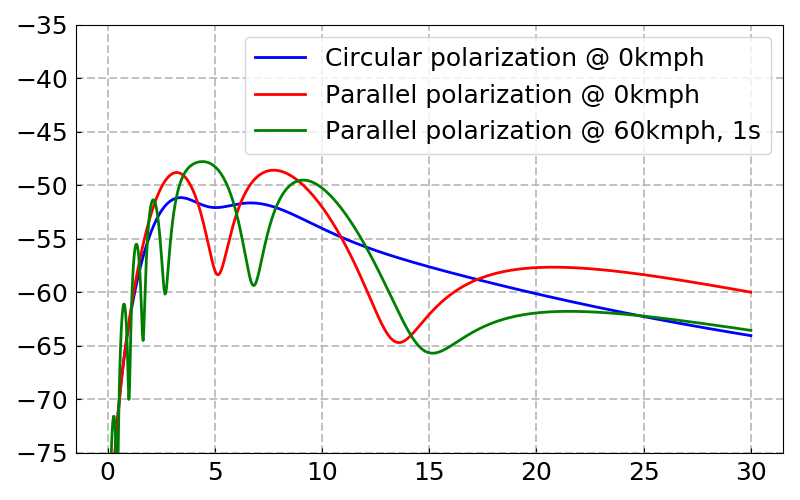

In [9]:
dist = linspace(0., 30, 1000)

pathloss_c0= [prs.lin2db(two_ray_3d_(d, 0.0, 0, 0.5)) for d in dist]
pathloss_p0 = [prs.lin2db(two_ray_3d_(d, 0.0, 0, 1)) for d in dist]
pathloss_p2 = [prs.lin2db(two_ray_3d_(d, 1., 60/3.6, 1)) for d in dist]

fig = figure(4, figsize=(8,5))
plt.rc('font', family='sans-serif')
ax = subplot(111)

plot(dist, pathloss_c0, 'b', linewidth=2, label='Circular polarization @ 0kmph')
plot(dist, pathloss_p0, 'r', linewidth=2, label='Parallel polarization @ 0kmph')
plot(dist, pathloss_p2, 'g', linewidth=2, label='Parallel polarization @ 60kmph, 1s')

grid(linestyle='--', linewidth=1.1)
ax.set_yticks(arange(-75, -30, 5))
ax.set_ybound(lower=-75)
ax.tick_params(labelsize=18, direction='in', pad=6)
# ax.set_xlabel("Distance")
# ax.set_ylabel("Loss, Db")
# ax.set_title('Path Loss Models\n(tag angle = 90 deg, reader angle = 45 deg)')
legend(fontsize=18)

fig.tight_layout()
savefig('pathloss_cases.eps')

<IPython.core.display.Javascript object>


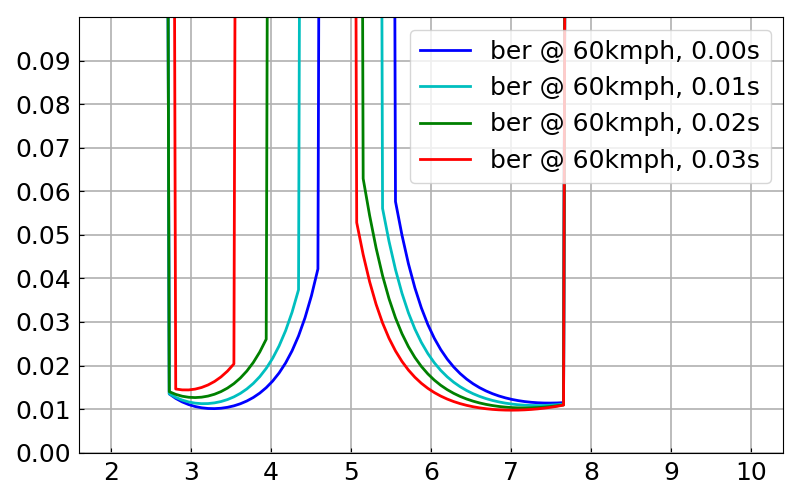

In [13]:
dist  = linspace(2, 10, 100)
ber_0 = [ber_over_rayleigh_3d_(d, 0.00, 60/3.6) for d in dist]
ber_1 = [ber_over_rayleigh_3d_(d, 0.01, 60/3.6) for d in dist]
ber_2 = [ber_over_rayleigh_3d_(d, 0.02, 60/3.6) for d in dist]
ber_3 = [ber_over_rayleigh_3d_(d, 0.03, 60/3.6) for d in dist]

fig = figure(40, figsize(8, 5))
ax = subplot(111)
plt.rc('font', family='sans-serif')

plot(dist, ber_0, 'b', label='ber @ 60kmph, 0.00s', linewidth=2)
plot(dist, ber_1, 'c', label='ber @ 60kmph, 0.01s', linewidth=2)
plot(dist, ber_2, 'g', label='ber @ 60kmph, 0.02s', linewidth=2)
plot(dist, ber_3, 'r', label='ber @ 60kmph, 0.03s', linewidth=2)

ax.set_yticks(arange(0.0, 0.1, 0.01))
ax.set_ybound(lower=0, upper=0.1)
ax.tick_params(labelsize=18, direction='in', pad=6)

grid(linewidth=1.2)
legend(fontsize=18)
fig.tight_layout()

savefig('ber_cases.eps')

<IPython.core.display.Javascript object>


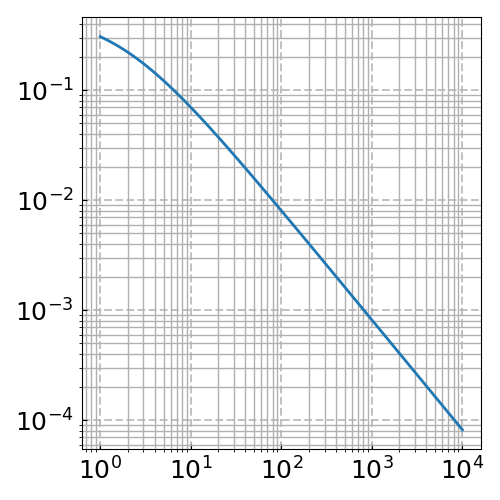

In [10]:
snr = [prs.db2lin(dbm) for dbm in linspace(0, 40, 100)]

ber = [prs.ber_over_rayleigh(snr=snr_i) for snr_i in snr]

fig = figure(50, figsize(5, 5))
ax = subplot(111)
# plt.rc('font', family='sans-serif')

loglog(snr, ber, linewidth=2)

ax.tick_params(labelsize=18, direction='in', pad=6)

grid(linewidth=1., which='minor')
grid(linewidth=1.1, linestyle='--', which='major')

# legend(fontsize=18)
fig.tight_layout()

# savefig('ber-plot.eps')

<IPython.core.display.Javascript object>


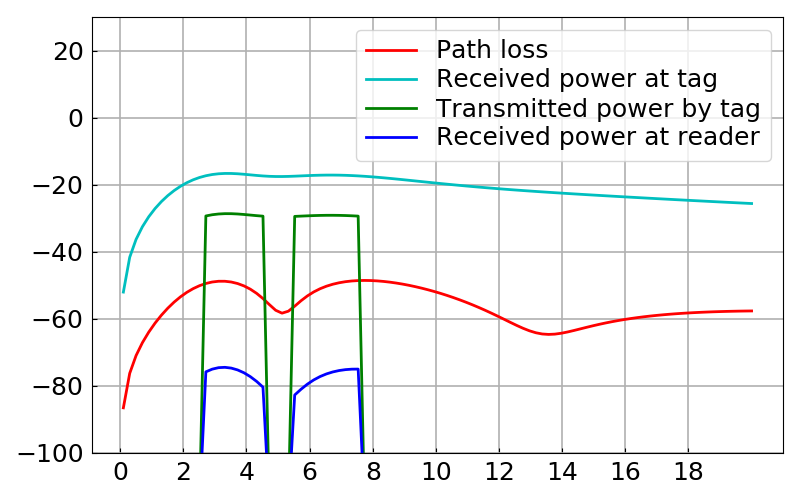

In [11]:
dist = linspace(0.1, 20, 100)

# pathloss_f = [prs.lin2db(two_ray_3d_(d, 0.0, 0, 0.5))     for d in dist]
# to emulate the vehicle passing through, put a list with [d/t] as the second parameter
pathloss_b = [prs.lin2db(two_ray_3d_(d, 0.0, 0, 1))       for d in dist]
rx_reader  = [rx_power_reader_complete_3d_(d, .0, 60/3.6) for d in dist]
rx_tag     = [rx_power_tag_complete_3d_(d, .0, 60/3.6)    for d in dist]
tx_tag     = [tx_power_tag_complete_3d_(d, .0, 60/3.6)    for d in dist]

fig = figure(41, figsize(8, 5))
ax = subplot(111)
plt.rc('font', family='sans-serif')

# plot(dist, pathloss_f, label='Pathloss from reader to tag', linewidth=2)
plot(dist, pathloss_b, 'r', label='Path loss',                linewidth=2)
plot(dist, rx_tag,     'c', label='Received power at tag',    linewidth=2)
plot(dist, tx_tag,     'g', label='Transmitted power by tag', linewidth=2)
plot(dist, rx_reader,  'b', label='Received power at reader', linewidth=2)


# ax.set_yticks(arange(0.0, 0.1, 0.01))
ax.set_xticks(arange(0.0, 20, 2))
ax.set_ybound(lower=-100, upper=30)
ax.tick_params(labelsize=18, direction='in', pad=6)

grid(linewidth=1.2)

legend(fontsize=18, labelspacing=0.2)
fig.tight_layout()

savefig('link_budget.eps')

In [16]:
distance = np.linspace(1, 10., 300)
time     = np.linspace(0, 2, 300)

# pathloss_greed = prs.lin2db(make_space_time_greed_(distance, time, two_ray_3d_, speed=tag_speed, polarization=1))
# rx_tag_greed       = make_space_time_greed_(distance, time, rx_power_tag_complete_3d_, speed=tag_speed)
# rx_reader_greed    = make_space_time_greed_(distance, time, rx_power_reader_complete_, speed=tag_speed)
# ber_awgn_greed     = make_space_time_greed_(distance, time, ber_over_awgn_3d_, speed=tag_speed)
ber_rayleigh_greed = make_space_time_greed_(distance, time, ber_over_rayleigh_3d_, speed=tag_speed)

<IPython.core.display.Javascript object>


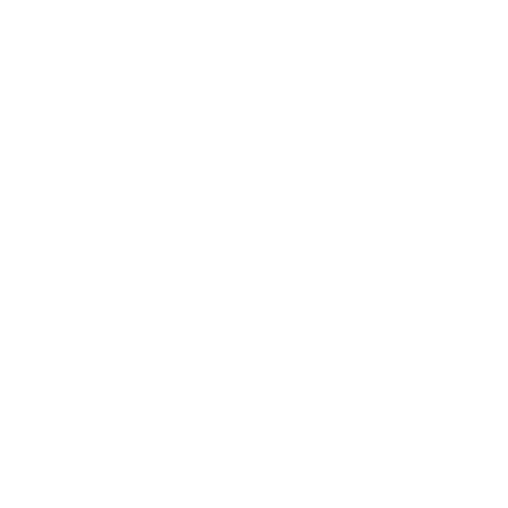

NameError: name 'pathloss_greed' is not defined

In [17]:
fig = plt.figure(501, figsize=(5.08, 5.08)) # 2 inches

D,T = meshgrid(distance, time)
P = pathloss_greed

im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=-2*np.arange(np.floor(P.max()-P.min())/2) + np.floor(P.max()))
cbar.ax.tick_params(labelsize=13)

im.axes.set_xticks(np.arange(10) + 1)
im.axes.set_yticks(0.2*np.arange(11))
plt.tick_params(labelsize=13)

# plt.title('Bit Error Probability', fontdict={'fontsize': 16})
fig.tight_layout()
savefig('pathloss.eps', dpi = 250, facecolor='w', edgecolor='w')

In [ ]:
fig = plt.figure(502, figsize=(5.08, 5.08)) # 2 inches

D,T = meshgrid(distance, time)
P = rx_tag_greed

im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=-np.arange(np.floor(P.max()-P.min())) + np.floor(P.max()))
cbar.ax.tick_params(labelsize=13)

im.axes.set_xticks(np.arange(10) + 1)
im.axes.set_yticks(0.2*np.arange(11))
plt.tick_params(labelsize=13)

# plt.title('Bit Error Probability', fontdict={'fontsize': 16})
fig.tight_layout()
savefig('rx_tag.eps', dpi = 250, facecolor='w', edgecolor='w')


<IPython.core.display.Javascript object>


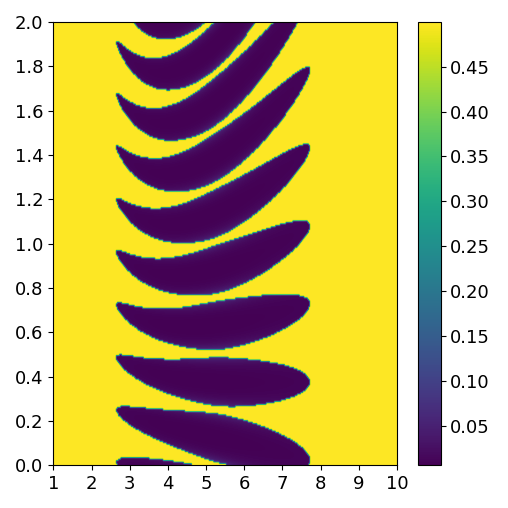

In [18]:
fig = plt.figure(503, figsize=(5.08, 5.08)) # 2 inches

D,T = meshgrid(distance, time)
P = ber_rayleigh_greed


im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=-0.05*np.arange(12) + 0.5)
cbar.ax.tick_params(labelsize=13)

im.axes.set_xticks(np.arange(10) + 1)
im.axes.set_yticks(0.2*np.arange(11))
plt.tick_params(labelsize=13)

# plt.title('Bit Error Probability', fontdict={'fontsize': 16})
fig.tight_layout()
# savefig('ber.eps', dpi = 250, facecolor='w', edgecolor='w')

# min_ber = 0.5
# cum = 0
# count = 0
# for ber_a in ber_rayleigh_greed:
#     for ber in ber_a:
#         if min_ber > ber:
#             min_ber = ber
#         if ber < 0.02:
#             cum += ber
#             count += 1

# min_ber, count/300/300, cum/count 

In [19]:
ref_min = 0.1
ref_max = 0.4
ref = ref_min
counts = np.zeros(2000)

for t in range(2000):
    for d in range(2000):
        ber__ = ber_awgn_greed_3[t][d]
        if ref == ref_min and ber__ < ref:
            ref = ref_max
            counts[t] = counts[t] + 1
        elif ref == ref_max and ber__ > ref:
            ref = ref_min


NameError: name 'ber_awgn_greed_3' is not defined

In [ ]:
fig = figure(9)
ax = subplot(111)
plot(time_3, counts,'g', label='Free-space path loss')
grid(True)

In [ ]:
pathloss_0_ = prs.lin2db(two_ray_3d_(10, 0, 0, 1))
pathloss_1_ = prs.lin2db(two_ray_3d_inverse_(10, 0, 0, 1))
# rx_tag__   = rx_power_tag_(pathloss__)
print(pathloss_0_, pathloss_1_)

In [ ]:
distance = np.linspace(2, 10., 300)
time     = np.linspace(0, 2, 300)

def log_two_ray_3d_(distance, time, speed, polarization): 
    return prs.lin2db(two_ray_3d_(distance, time, speed, polarization))

pathloss_greed_complete = make_space_time_greed_(distance, time, log_two_ray_3d_, speed=tag_speed, polarization=.5)
# rx_tag_greed_complete       = make_space_time_greed_(distance, time, rx_power_tag_complete_3d_, speed=tag_speed)
# rx_reader_greed    = make_space_time_greed_(distance, time, rx_power_reader_complete_, speed=tag_speed)
# ber_awgn_greed     = make_space_time_greed_(distance, time, ber_over_awgn_, speed=tag_speed)
# ber_rayleigh_greed = make_space_time_greed_(distance, time, ber_over_rayleigh_, speed=tag_speed)

In [ ]:
fig = plt.figure(15, figsize=(10,15))

D,T = meshgrid(distance, time)
P = pathloss_greed_complete
plt.contourf(D, T, P, 500)            
plt.colorbar()
# savefig('100kmps_4sec.png')

## Protocol analysis

In [13]:
import protocol


In [14]:
def get_query_frame(tari, rtcal, trcal, session, dr, m, trext, sel, target, q, crc5=0x1F):
    preamble = protocol.ReaderFrame.Preamble(tari=tari, rtcal=rtcal, trcal=trcal)
    command = protocol.Query(dr, m, trext, sel, target, q, crc5)
    frame = protocol.ReaderFrame(preamble, command)
    return frame

def get_qrep_frame(tari, rtcal, session):
    sync = protocol.ReaderFrame.Sync(tari, rtcal)
    command = protocol.QueryRep(session)
    frame = protocol.ReaderFrame(sync, command)
    return frame
    
def get_ack_frame(tari, rtcal, rn=0xFFFF):
    sync = protocol.ReaderFrame.Sync(tari, rtcal)
    command = protocol.Ack(rn)
    frame = protocol.ReaderFrame(sync, command)
    return frame

def get_reqrn_frame(tari, rtcal, rn=0xFFFF, crc16=0xFFFF):
    sync = protocol.ReaderFrame.Sync(tari, rtcal)
    command = protocol.ReqRn(rn, crc16)
    frame = protocol.ReaderFrame(sync, command)
    return frame
    
def get_read_frame(tari, rtcal, bank=protocol.Bank.TID, wordptr=0x00, wordcnt=4, rn=0xFFFF, crc16=0xFFFF):
    sync = protocol.ReaderFrame.Sync(tari, rtcal)
    command = protocol.Read(bank, wordptr, wordcnt, rn, crc16)
    frame = protocol.ReaderFrame(sync, command)
    return frame

def get_query_reply_frame(m, trext, blf, rn=0xFFFF):
    reply = protocol.Rn16Reply(rn)
    frame = protocol.TagFrame(m, trext, blf, reply)
    return frame

def get_ack_reply_frame(m, trext, blf, epc=0xFFFFFFFFFFFFFFFFFFFFFFFF, pc=0, crc16=0xFFFF):
    reply = protocol.AckReply(epc, pc, crc16)
    frame = protocol.TagFrame(m, trext, blf, reply)
    return frame

def get_reqrn_reply_frame(m, trext, blf, rn=0xFFFF, crc16=0xFFFF):
    reply = protocol.ReqRnReply(rn, crc16)
    frame = protocol.TagFrame(m, trext, blf, reply)
    return frame

def get_read_reply_frame(m, trext, blf, words=0xFFFFFFFFFFFFFFFF, rn=0xFFFF, crc16=0xFFFF):
    reply = protocol.ReadReply(words, rn, crc16)
    frame = protocol.TagFrame(m, trext, blf, reply)
    return frame

def get_blf(trcal, dr):
    return dr.ratio / trcal

def get_t1(rtcal, trcal, dr, maximum=True):
    blf = get_blf(trcal, dr)
    return protocol.max_t1(rtcal, blf) if maximum else protocol.min_t1(rtcal, blf)

def get_t2(trcal, dr, maximum=True):
    blf = get_blf(trcal, dr)
    return protocol.max_t2(blf) if maximum else protocol.min_t2(blf)

def get_t3():
    return 0.0

def get_t4(rtcal):
    return protocol.t4(rtcal)
    

In [29]:
def get_rtcal(tari, data1_multiplier=2.0): 
    return (data1_multiplier + 1) * tari

def get_trcal(tari, rtcal_multiplier=2.0, data1_multiplier=2.0): 
    return rtcal_multiplier * get_rtcal(tari, data1_multiplier)

def get_q_frame(tari, m, first=False):
    rtcal = get_rtcal(tari)
    trcal = get_trcal(tari)
    query = None
    if first:
        query = get_query_frame(tari, rtcal, trcal, session=protocol.Session.S3, dr=protocol.DR.DR_8, 
                                m=m, trext=True, sel=protocol.Sel.SL_YES, 
                                target=protocol.InventoryFlag.B, q=0xF)
    else:
        query = get_qrep_frame(tari, rtcal, session=protocol.Session.S3)
    return query

def get_max_empty_slot_duration(tari, m, first=False):
    rtcal = get_rtcal(tari)
    trcal = get_trcal(tari)
    query = get_q_frame(tari, m)
    t1 = get_t1(rtcal, trcal, protocol.DR.DR_8)
    t3 = get_t3()
    return query.duration + t1 + t3

def get_max_inventory_slot_duration(tari, m, first=False):
    rtcal = get_rtcal(tari)
    trcal = get_trcal(tari)
    blf = get_blf(trcal, protocol.DR.DR_8)
    query = get_q_frame(tari, m)
    rn16 = get_query_reply_frame(m, True, blf)
    ack = get_ack_frame(tari, rtcal)
    response = get_ack_reply_frame(m, True, blf)
    t1 = get_t1(rtcal, trcal, protocol.DR.DR_8)
    t2 = get_t2(trcal, protocol.DR.DR_8)
    return query.duration + t1 + rn16.duration + t2 + ack.duration + t1 + response.duration + t2

def get_max_access_slot_duration(tari, m, first=False):
    rtcal = get_rtcal(tari)
    trcal = get_trcal(tari)
    blf = get_blf(trcal, protocol.DR.DR_8)
    t1 = get_t1(rtcal, trcal, protocol.DR.DR_8)
    t2 = get_t2(trcal, protocol.DR.DR_8)
    inventory_duration = get_max_inventory_slot_duration(tari, m, first)
    reqrn = get_reqrn_frame(tari, rtcal)
    handle = get_reqrn_reply_frame(m, True, blf)
    readcmd = get_read_frame(tari, rtcal)
    readrep = get_read_reply_frame(m, True, blf)
    return (inventory_duration + reqrn.duration + t1 + handle.duration + t2 + readcmd.duration + 
            t1 + readrep.duration + t2)

def get_max_collision_slot_duration(tari, m, first=False):
    rtcal = get_rtcal(tari)
    trcal = get_trcal(tari)
    blf = get_blf(trcal, protocol.DR.DR_8)
    query = get_q_frame(tari, m)
    rn16 = get_query_reply_frame(m, True, blf)
    t1 = get_t1(rtcal, trcal, protocol.DR.DR_8)
    t2 = get_t2(trcal, protocol.DR.DR_8)
    return query.duration + t1 + rn16.duration + t2

def get_query_and_qrep_delta(tari, m):
    rtcal = get_rtcal(tari)
    trcal = get_trcal(tari)
    query = get_query_frame(tari, rtcal, trcal, session=protocol.Session.S3, dr=protocol.DR.DR_8, 
                                m=m, trext=True, sel=protocol.Sel.SL_YES, 
                                target=protocol.InventoryFlag.B, q=0xF)
    qrep = get_qrep_frame(tari, rtcal, session=protocol.Session.S3)
    return query.duration - qrep.duration

def get_max_round_duration(tari, m, q, n_tags, read_tid=True):
    n_slots = 2 ** q
    
    if n_tags == 0:
        return (get_max_empty_slot_duration(tari, m, True) + 
                (n_slots - 1) * get_max_empty_slot_duration(tari, m, False))
    
    n_error = 1 if n_tags > n_slots else 0
    n_empty = 0 if n_tags >= n_slots else n_slots - n_tags
    n_busy  = n_slots - (n_error + n_empty)
    n_qqd   = 1 if n_slots > 1 else 0
    
#     print("num collisions: {}, num empty slots: {}, num busy slots: {}".format(
#         num_collisions, num_empty_slots, num_busy_slots))
    
    t_empty = get_max_empty_slot_duration(tari, m)
    t_busy  = get_max_access_slot_duration(tari, m) if read_tid else get_max_inventory_slot_duration(tari, m)
    t_error = get_max_collision_slot_duration(tari, m)
    t_qqd   = get_query_and_qrep_delta(tari, m)
    
    return n_empty * t_empty + n_busy * t_busy + n_error * t_error + n_qqd * t_qqd
    

print("empty     slot: {}".format(get_max_empty_slot_duration(6.25e-6, protocol.TagEncoding.M8)))
print("inventory slot: {}".format(get_max_inventory_slot_duration(6.25e-6, protocol.TagEncoding.M8)))
print("access    slot: {}".format(get_max_access_slot_duration(6.25e-6, protocol.TagEncoding.M8)))
print("collision slot: {}".format(get_max_collision_slot_duration(6.25e-6, protocol.TagEncoding.M8)))
print("max round duration = {}".format(get_max_round_duration(6.25e-6, protocol.TagEncoding.M8, 2, 2)))



empty     slot: 0.00012856250000000001
inventory slot: 0.007750875000000001
access    slot: 0.0157455
collision slot: 0.0016848125000000001
max round duration = 0.032004374999999995


<IPython.core.display.Javascript object>


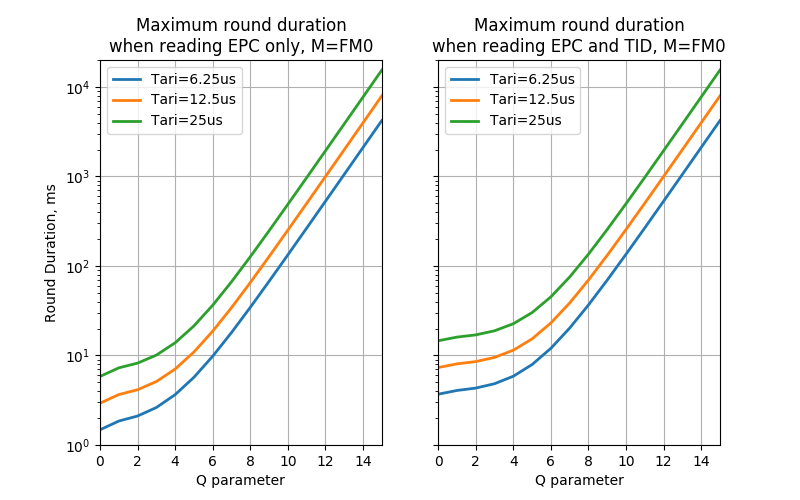

In [104]:
q_values = range(0, 16)
tari_values = [6.25e-6, 12.5e-6, 25e-6]
n_tags = 1
m = protocol.TagEncoding.FM0

round_durations_epc = [[get_max_round_duration(tari, m, q, n_tags, False) * 1e3 for q in q_values] 
                       for tari in tari_values]
round_durations_tid = [[get_max_round_duration(tari, m, q, n_tags, True) * 1e3 for q in q_values] 
                       for tari in tari_values]

fig = figure(1000)

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_yscale('log')
ax1.plot(q_values, round_durations_epc[0], label='Tari=6.25us', linewidth=2)
ax1.plot(q_values, round_durations_epc[1], label='Tari=12.5us', linewidth=2)
ax1.plot(q_values, round_durations_epc[2], label='Tari=25us', linewidth=2)
ax1.set_xlabel('Q parameter')
ax1.set_ylabel('Round Duration, ms')
ax1.set_title('Maximum round duration\nwhen reading EPC only, M=FM0')
ax1.set_xticks(range(0, 16, 2))
ax1.set_xbound(lower=0, upper=15)
ax1.set_ybound(lower=1, upper=1e4*2)
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_yscale('log')
ax2.plot(q_values, round_durations_tid[0], label='Tari=6.25us', linewidth=2)
ax2.plot(q_values, round_durations_tid[1], label='Tari=12.5us', linewidth=2)
ax2.plot(q_values, round_durations_tid[2], label='Tari=25us', linewidth=2)
ax2.set_xlabel('Q parameter')
# ax2.set_ylabel('Round Duration, ms')
ax2.set_title('Maximum round duration\nwhen reading EPC and TID, M=FM0')
ax2.set_xticks(range(0, 16, 2))
ax2.set_xbound(lower=0, upper=15)
ax2.set_ybound(lower=1, upper=1e4*2)
ax2.set_yticklabels([])
ax2.grid()
ax2.legend()

<IPython.core.display.Javascript object>


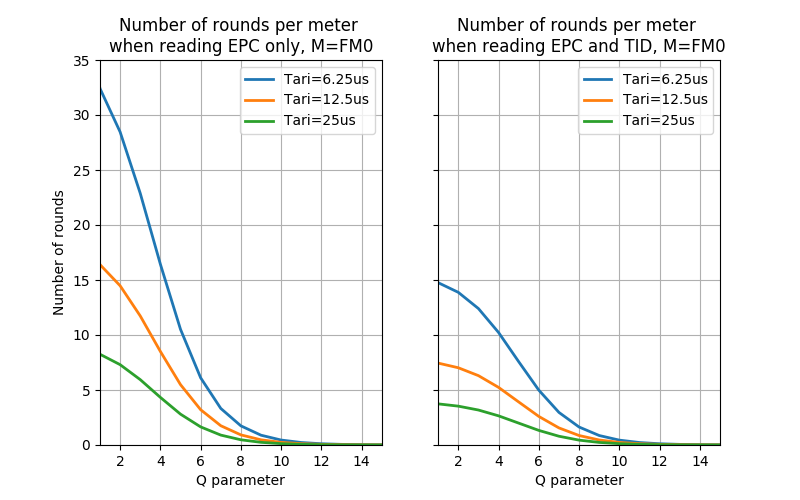

In [105]:
q_values = range(0, 16)
tari_values = [6.25e-6, 12.5e-6, 25e-6]
n_tags = 1
m = protocol.TagEncoding.FM0

round_durations_epc = [[get_max_round_duration(tari, m, q, n_tags, False) * 1e3 for q in q_values] 
                       for tari in tari_values]
round_durations_tid = [[get_max_round_duration(tari, m, q, n_tags, True) * 1e3 for q in q_values] 
                       for tari in tari_values]

distance = 1.0
vehicle_speed = 60.0 / 3.6

vehicle_passing_time = distance / vehicle_speed
n_rounds_epc = [[(vehicle_passing_time * 1e3) / d for d in durations] for durations in round_durations_epc]
n_rounds_tid = [[(vehicle_passing_time * 1e3) / d for d in durations] for durations in round_durations_tid]

fig = figure(1001)

ax1 = fig.add_subplot(1, 2, 1)
# ax1.set_yscale('log')
ax1.plot(q_values, n_rounds_epc[0], label='Tari=6.25us', linewidth=2)
ax1.plot(q_values, n_rounds_epc[1], label='Tari=12.5us', linewidth=2)
ax1.plot(q_values, n_rounds_epc[2], label='Tari=25us', linewidth=2)
ax1.set_xlabel('Q parameter')
ax1.set_ylabel('Number of rounds')
ax1.set_title('Number of rounds per meter \nwhen reading EPC only, M=FM0')
ax1.set_xticks(range(0, 16, 2))
ax1.set_xbound(lower=1, upper=15)
ax1.set_ybound(lower=0, upper=35)
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
# ax1.set_yscale('log')
ax2.plot(q_values, n_rounds_tid[0], label='Tari=6.25us', linewidth=2)
ax2.plot(q_values, n_rounds_tid[1], label='Tari=12.5us', linewidth=2)
ax2.plot(q_values, n_rounds_tid[2], label='Tari=25us', linewidth=2)
ax2.set_xlabel('Q parameter')
# ax2.set_ylabel('Number of rounds')
ax2.set_title('Number of rounds per meter \nwhen reading EPC and TID, M=FM0')
ax2.set_xticks(range(0, 16, 2))
ax2.set_xbound(lower=1, upper=15)
ax2.set_ybound(lower=0, upper=35)
ax2.set_yticklabels([])
ax2.grid()
ax2.legend()
